In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from windtools.common import covariance
from windtools.inflow.synthetic import TurbSim

In [3]:
outdir = '/projects/mmc/equon/turbsim'

In [4]:
#
# perturbation parameters
#
turbsim_prefix = '/projects/mmc/equon/turbsim/SWiFT_20131108_neutral'

halfthick = 50.0 # half-thickness of the layer transitioning from full perturbations to no perturbations
pert_freq = 10.0 # how often to add perturbations [s]

# reference values
zref = 74.7 # interpolate mesoscale data to this height
TIref = 0.10 # turbsim input [-]
Uref = 12.0 # turbsim input [m/s]
uuref = (Uref*TIref)**2

In [5]:
#
# coupled microscale simulation parameters
#
domain_height = 1000.0
domain_width = 5000.0
spacing = 10.0

## read data

In [6]:
%time ts = TurbSim(turbsim_prefix, verbose=True)

# 1 km x 1 km:
# CPU times: user 4min 41s, sys: 765 ms, total: 4min 42s
# Wall time: 4min 42s

Reading header information from /projects/mmc/equon/turbsim/SWiFT_20131108_neutral.bts
  id= 8 (periodic)
  NumGrid_Z,_Y= 101 101
  ntower= 0
  nt= 12096
  (problem size: 370173888 points)
  dz,dy= 10.0 10.0
  TimeStep= 0.05
  Period= 604.8
  Umean = uhub = 12.0 (for calculating fluctuations)
  HubHt= 501.0  (NOT USED)
  Zbottom= 1.0
  Vslope= [5234.304  6653.7617 9680.994 ]
  Vintercept= [-63909.46       291.46875  -1513.0137 ]
b'This full-field file was generated by TurbSim on 24-Oct-2019 at 15:47:42.'
Reading normalized grid data
  U size : 1412.101318359375 MB
  Read velocitiy fields in 298.61 s
Calculating velocities from normalized data
  u min/max [ -6.050506 6.469782 ]
  v min/max [ -4.9685383 4.880778 ]
  w min/max [ -3.2284894 3.5409603 ]
Calculating coordinates
Read times [ 0.0 0.05 ... 604.75 ]
CPU times: user 5min 1s, sys: 696 ms, total: 5min 2s
Wall time: 5min 2s


In [7]:
# %%time
# # tile the domain
# ts_width = np.max(ts.y) - np.min(ts.y)
# ntiles = int(np.ceil(domain_width / ts_width))
# print(ntiles,'tiles needed for simulated inflow plane width of',ts_width)
# ts.tileY(ntiles=ntiles, mirror=True)

# # CPU times: user 6.18 s, sys: 3.78 s, total: 9.96 s
# # Wall time: 9.98 s

In [8]:
%%time
# calculate reference variances from turbsim, should be close to input TI
uu_sim = np.mean(np.var(ts.U[0,:,:,:],axis=0))
vv_sim = np.mean(np.var(ts.U[1,:,:,:],axis=0))
ww_sim = np.mean(np.var(ts.U[2,:,:,:],axis=0))

# CPU times: user 6.99 s, sys: 2.27 s, total: 9.27 s
# Wall time: 9.29 s

CPU times: user 2.02 s, sys: 287 ms, total: 2.31 s
Wall time: 2.32 s


Text(0.5, 0, 'time [s]')

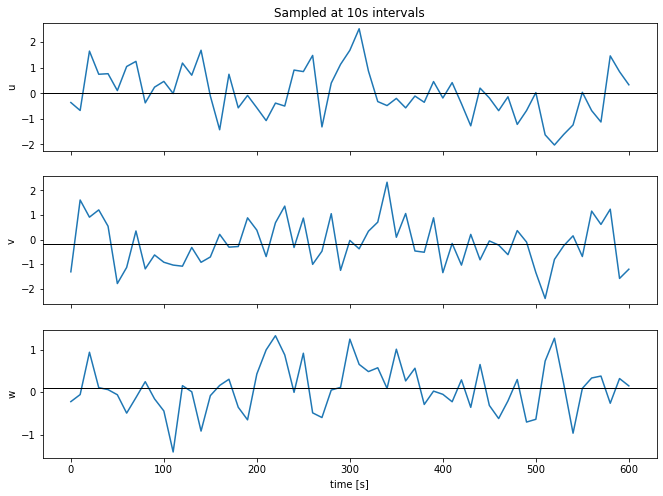

In [9]:
# plot fluctuations in u,v,w
j,k = 0,8
tskip = int(np.round(pert_freq/ts.dt, decimals=2))
fig,ax = plt.subplots(nrows=3,sharex=True,figsize=(11,8))
for i in range(3):
    ax[i].plot(ts.t[::tskip],ts.U[i,::tskip,j,k])
    ax[i].axhline(np.mean(ts.U[i,::tskip,j,k]), color='k', lw=1)
ax[0].set_title('Sampled at {:g}s intervals'.format(tskip*ts.dt))
ax[0].set_ylabel('u')
ax[1].set_ylabel('v')
ax[2].set_ylabel('w')
ax[-1].set_xlabel('time [s]')

## checks

In [10]:
# sanity checks

# - IEC turbulence characteristic (IECturbc) == 10.0
print('Estimated TI from turbsim output:', 100 * np.sqrt(uu_sim) / Uref) 

# - assumed variances (IEC): 0.8, 0.5
print('sigma_v/sigma_u, sigma_w/sigma_u from turbsim output:', np.sqrt(vv_sim/uu_sim), np.sqrt(ww_sim/uu_sim)) 

Estimated TI from turbsim output: 9.538732965787252
sigma_v/sigma_u, sigma_w/sigma_u from turbsim output: 0.8195899 0.51231503


### check covariance

In [11]:
ts_U = ts.U[0,:,:,:].reshape((ts.N, ts.NY*ts.NZ))
ts_V = ts.U[1,:,:,:].reshape((ts.N, ts.NY*ts.NZ))
for itime in range(ts.N):
    assert np.all(ts_U[itime,:] == ts.U[0,itime,:,:].ravel())
    assert np.all(ts_V[itime,:] == ts.U[1,itime,:,:].ravel())

In [12]:
tidx = pd.to_timedelta(ts.t, unit='s')
udata = pd.DataFrame(ts_U, index=tidx)
vdata = pd.DataFrame(ts_V, index=tidx)

In [13]:
%%time
uv = covariance(udata, vdata, '10min', resample=True)
# we get > 1 resampled value because our period is slightly higher than 10 min
uv

CPU times: user 973 ms, sys: 696 ms, total: 1.67 s
Wall time: 1.68 s


,0,1,2,3,4,5,6,7,8,9,...,10191,10192,10193,10194,10195,10196,10197,10198,10199,10200
00:00:00,-0.047272,-0.017609,0.090505,0.120074,0.038882,0.063150,-0.054018,-0.092591,-0.077092,-0.145920,...,0.048774,-0.090690,0.083786,0.058956,0.072979,0.107698,0.086650,-0.022111,-0.022508,0.264482
00:10:00,0.122269,-0.099945,0.046254,-0.057368,-0.159539,-0.029424,-0.220947,0.151577,0.028741,-0.027808,...,-0.000307,0.074392,0.026622,0.003015,0.025088,0.070496,0.051694,0.196314,0.135484,0.006449


In [14]:
uv_ref = uv.iloc[0].mean()

In [15]:
# should be ~0 because the coherence model does not correlate u with v or w
uv_ref

-0.00021159253

## output

In [16]:
# %%time
# np.savez_compressed(os.path.join(outdir,'turbsim_planes.npz'),
#                     U=ts.U, y=ts.y, z=ts.z, dt=ts.dt)

# CPU times: user 21min 4s, sys: 8.3 s, total: 21min 13s
# Wall time: 21min 40s

In [20]:
ds = xr.Dataset(
    data_vars={
        'U': (('N','NY','NZ'), ts.U[0,:,:,:]),
        'V': (('N','NY','NZ'), ts.U[1,:,:,:]),
        'W': (('N','NY','NZ'), ts.U[2,:,:,:]),
    },
    coords={
        't': ('N', ts.t),
        'y': ('NY', ts.y),
        'z': ('NZ', ts.z),
    },
)

In [21]:
ds

<xarray.Dataset>
Dimensions:  (N: 12096, NY: 101, NZ: 101)
Coordinates:
    t        (N) float32 0.0 0.05 0.1 0.15 0.2 ... 604.60004 604.65 604.7 604.75
    y        (NY) float32 0.0 10.0 20.0 30.0 40.0 ... 970.0 980.0 990.0 1000.0
    z        (NZ) float32 1.0 11.0 21.0 31.0 41.0 ... 971.0 981.0 991.0 1001.0
Dimensions without coordinates: N, NY, NZ
Data variables:
    U        (N, NY, NZ) float32 1.7952356 1.9752026 ... -1.1774607 -0.92699814
    V        (N, NY, NZ) float32 0.24505405 -0.6428647 ... -0.9114346 -1.07435
    W        (N, NY, NZ) float32 0.51306856 0.46152425 ... -1.0818089 0.07664643

In [22]:
ds.to_netcdf('turbsim_planes.nc')